In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import json
import os
import yaml
print(yaml.__file__)
from pathlib import Path
from dask.distributed import Client
import dask

/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/yaml/__init__.py


In [4]:
use_local=True

In [5]:
if not use_local:
    with open(f'~/.dlio_profiler/configuration.yaml', 'r') as file:
        dlp_yaml = yaml.safe_load(file)
        app_root = dlp_yaml["app"]
else:
    app_root = str(Path(os.getcwd()).parent.parent)

In [6]:
# to make this notebook in dev mode.
import sys
sys.path.insert(0, app_root)
sys.path

['/usr/WS2/haridev/dyad/tests/integration',
 '/usr/WS2/haridev/dyad/tests/integration/dlio_benchmark/perf_analysis',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python39.zip',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9/lib-dynload',
 '',
 '/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages']

In [7]:
import dlp_analyzer
print(dlp_analyzer.__file__)
from dlp_analyzer.main import DLPAnalyzer,get_dlp_configuration,update_dlp_configuration,setup_logging,setup_dask_cluster, reset_dask_cluster, get_dlp_configuration

/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/__init__.py


In [8]:
if not use_local:
    dask_run_dir = os.path.join(app_root, "dlp_analyzer", "dask", "run_dir")
    with open (os.path.join(dask_run_dir, f"scheduler_{os.getenv('USER')}.json"), "r") as f:
        dask_scheduler = json.load(f)["address"]
else:
    dask_scheduler = None

In [9]:
app_name = "dyad_dlio_unet3d" # resnet cosmoflow unet3d mummi deepspeed dlio_resnet dlio_cosmoflow dyad_dlio_unet3d

In [10]:
def get_conditions_dyad_dlio_unet3d(json_object):
    app_io_cond = "getitem" in json_object["cat"] # dyad_dlio_unet3d
    compute_cond = "compute" in json_object["name"] # dyad_dlio_unet3d
    io_cond = "POSIX" == json_object["cat"] # dyad_dlio_unet3d
    return app_io_cond, compute_cond, io_cond
def get_conditions_cosmoflow(json_object):
    app_io_cond = "TFReader.parse_image" in json_object["name"] # Cosmoflow
    compute_cond = "compute" in json_object["name"] # Cosmoflow
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_resnet(json_object):
    app_io_cond = "IO" == json_object["cat"] # Resnet50
    compute_cond = "cpu" in json_object["name"] or "compute" in json_object["cat"] # Resnet50
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_unet3d(json_object):
    app_io_cond = "NPZReader.read_index" in json_object["name"] # Unet3d
    compute_cond = "compute" in json_object["name"] # Unet3d
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_dlio_resnet(json_object):
    app_io_cond = "read_index" in json_object["name"] # Unet3d
    compute_cond = "compute" in json_object["name"] # Unet3d
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond


In [11]:
condition_fn = None #
if app_name == "cosmoflow":
    filename = "/usr/WS2/iopp/kogiou1/dlio_benchmark/hydra_log/cosmoflow/2023-10-31-10-27-24/.trace*.pfw.gz"
    condition_fn = get_conditions_cosmoflow
elif app_name == "dlio_cosmoflow":
    filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark/hydra_log/cosmoflow/2023-11-01-18-47-58/.trace*.pfw.gz"
    condition_fn = get_conditions_cosmoflow
elif app_name == "resnet":
    filename = "/usr/workspace/iopp/dlio_paper_results/resnet_50_1node_4ppn/*.pfw.gz"
    condition_fn = get_conditions_resnet
elif app_name == "unet3d":
    filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark_logs/unet3d/node_32_ppn_4/.trace*.pfw.gz"
    condition_fn = get_conditions_unet3d
elif app_name == "mummi":
    filename = "/usr/workspace/iopp/dlp_traces/mummi-32-node/trace*.pfw.gz"
elif app_name == "deepspeed":
    filename = "/usr/workspace/iopp/dlp_traces/deepspeed_8_4ppn/*.pfw.gz"
elif app_name == "dlio_resnet":
    filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark/hydra_log/resnet50/2023-11-01-10-52-58/.trace*.pfw.gz"
    condition_fn = get_conditions_dlio_resnet
elif app_name == "dyad_dlio_unet3d":
    filename = "/usr/workspace/ice4hpc/dlio/dyad_logs/node_2_ppn_8_full_unet3d_base/*.pfw"
    #filename = "/usr/workspace/ice4hpc/dlio/dyad_logs/ian_opts/n1_p8_br1/*.pfw"
    filename = "/usr/workspace/ice4hpc/dlio/dyad_logs/final_opts/n1_p8_br1/*.pfw"
    filename = "/usr/workspace/ice4hpc/dlio/dyad_logs/final_opts/n1_p8_br2/*.pfw"
    filename = "/usr/workspace/ice4hpc/dlio/dyad_logs/dlp/n_2_p_8_br_1/*.pfw"
    condition_fn = get_conditions_dyad_dlio_unet3d
else:
    raise Exception("Unknown App name")

In [12]:
def dyad_function(json_object, current_dict, time_approximate,condition_fn):
    d = {}
    if "args" in json_object:
        if "file_size" in json_object["args"]:
            d["size"] = int(json_object["args"]["file_size"])
        elif "inlen" in json_object["args"]:
            d["size"] = int(json_object["args"]["inlen"])
    return d

In [13]:
dict_fn = None
if app_name == "dyad_dlio_unet3d":
    dict_fn = dyad_function

In [14]:
conf = update_dlp_configuration(dask_scheduler=dask_scheduler, verbose=True, workers=16,
                                log_file=f"./dlp_{os.getenv('USER')}.log", rebuild_index=False, time_approximate=True, 
                                host_pattern=r'lassen(\d+)', time_granularity=10e6, skip_hostname=True, conditions=condition_fn)


In [15]:
conf = get_dlp_configuration()
conf.time_approximate
conf.time_granularity

10000000.0

In [16]:
setup_logging()

In [17]:
setup_dask_cluster()

[INFO] [14:02:08] Initialized Client with 16 workers and link http://127.0.0.1:8787/status [/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/main.py:670]
2024-01-24 14:02:08,915 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:08,959 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:08,965 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:09,022 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:09,028 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:09,105 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:09,109 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:09,149 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:09,155 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:09,202 - distributed.nanny - WARNING - Restarting worker
2024-01-24 14:02:09,207 - distributed.nanny - WARNING - Restarting worker
2024-01

In [18]:
reset_dask_cluster()

[INFO] [14:02:11] Restarting all workers [/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/main.py:658]


In [19]:
analyzer = DLPAnalyzer(filename, load_fn=dict_fn)

[INFO] [14:02:11] Created index for 0 files [/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/main.py:367]
[INFO] [14:02:11] Total size of all files are <dask.bag.core.Item object at 0x1555191026a0> bytes [/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/main.py:369]
[INFO] [14:02:21] Loaded events [/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/main.py:424]
[INFO] [14:02:21] Loaded plots with slope threshold: 45 [/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/main.py:430]


In [20]:
analyzer.events.head()

,name,cat,pid,tid,ts,te,dur,tinterval,trange,hostname,compute_time,io_time,app_io_time,total_time,filename,phase,size
0,__xstat,POSIX,0,4059738,20,256,236,<NA>,0.0,corona174,<NA>,236,<NA>,236,/l/ssd/haridev/dyad,2,<NA>
1,dyad_dtl_ucx_init,C_APP,0,4059738,319,87814,87495,<NA>,0.0,corona174,<NA>,<NA>,<NA>,0,<NA>,0,<NA>
2,dyad_dtl_init,C_APP,0,4059738,316,87857,87541,<NA>,0.0,corona174,<NA>,<NA>,<NA>,0,<NA>,0,<NA>
3,dyad_open,C_APP,0,4059738,311,87870,87559,<NA>,0.0,corona174,<NA>,<NA>,<NA>,0,<NA>,0,<NA>
4,dyad_dtl_ucx_rpc_unpack,C_APP,0,4059738,76725606,76725649,43,<NA>,7.0,corona174,<NA>,<NA>,<NA>,0,<NA>,0,<NA>


In [21]:
#analyzer.events[["io_time","compute_time","app_io_time"]].max().compute() / 1e6

In [22]:
# hydra_log/cosmoflow/2023-11-01-18-47-58/
items = analyzer.summary()
items

[INFO] [14:02:22] Total number of events in the workload are 558167 [/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/main.py:522]
[INFO] [14:02:22] Approximate True 291859838, 8882589.0, 14980739.0, 0.0,                3111727.0, 9209877.0, 0.0, 14980739.0 [/usr/WS2/haridev/dyad/env/python/lib/python3.9/site-packages/dlp_analyzer/main.py:476]


╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  Allocation    Scheduler Allocation Details                                                                     │
│                ├── Nodes: 2                                                                                     │
│                ├── Processes: 496                                                                               │
│                ├── Thread allocations across nodes (includes dynamically created threads)                       │
│                │   ├── Compute: 16                                                                              │
│                │   └── I/O: 443                                                                                 │
│                └── Events Recorded: 558K                                                                        │
│  Dataset       Description of Dataset Used                                                                      │
│                └── Files: 345                                                                                   │
│  I/O Behavior  Behavior of Application                                                                          │
│                ├── Split of Time in application                                                                 │
│                │   ├── Total Time: 291.860 sec                                                                  │
│                │   ├── Unoverlapped App Compute: 14.981 sec                                                     │
│                │   ├── Compute: 14.981 sec                                                                      │
│                │   ├── Overall I/O: 8.883 sec                                                                   │
│                │   ├── Unoverlapped I/O: 3.112 sec                                                              │
│                │   └── Unoverlapped Compute: 9.210 sec                                                          │
│                └── Metrics by function                                                                          │
│                    ├── Function       |count |                  size                   |                        │
│                    ├──                |      |min   |25    |mean  |median|75    |max   |                        │
│                    ├── __xstat        |62    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── open           |4K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── lseek          |8K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── read           |118K  |NA    |4KB   |521KB |128KB |3MB   |4MB   |                        │
│                    ├── close          |9K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── readlink       |10K   |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── open64         |5K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── __fxstat64     |9K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── lseek64        |313K  |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── write          |1K    |13    |73    |930KB |183   |2MB   |476MB |                        │
│                    ├── fcntl          |8K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── fsync          |60    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── opendir        |32    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── __xstat64      |144   |NA    |n

In [23]:
analyzer.events.query("cat == 'POSIX'").groupby("name")["size"].sum().compute() / 1024**3

name
__fxstat64     0.00000
__xstat        0.00000
close          0.00000
fcntl          0.00000
fsync          0.00000
lseek          0.00000
lseek64        0.00000
open           0.00000
open64         0.00000
read          58.49324
readlink       0.00000
write          1.27108
__xstat64      0.00000
mkdir          0.00000
opendir        0.00000
Name: size, dtype: double[pyarrow]

In [24]:
dask.compute(analyzer.events["ts"].min(), analyzer.events["te"].max()) 

(0, 291859838)

In [33]:
analyzer.events.query("cat == 'C_APP'")['name'].unique().compute()

0                     dyad_dtl_ucx_init
1                         dyad_dtl_init
2                             dyad_open
3               dyad_dtl_ucx_rpc_unpack
4              dyad_dtl_ucx_rpc_respond
5     dyad_dtl_ucx_establish_connection
6                 dyad_ucx_request_init
7                    dyad_send_callback
8                 dyad_ucx_request_wait
9                     dyad_dtl_ucx_send
10        dyad_dtl_ucx_close_connection
11                dyad_fetch_request_cb
12                             mod_main
13                dyad_dtl_ucx_finalize
14                    dyad_dtl_finalize
15                            dyad_init
16                         gen_path_key
17                   dyad_free_metadata
18                        dyad_kvs_read
19                    dyad_get_metadata
20                         dyad_produce
21                      dyad_kvs_commit
22                     publish_via_flux
23                          dyad_commit
24                      dyad_excl_flock


In [28]:
dlio_percieved=analyzer.events.query("name == 'DYADTorchDataset.__getitem__'").groupby("trange","tid","pid").agg({"dur":sum, "size":sum, "name":"count"}).groupby("trange").agg({"dur":max, "size":sum, "name":sum})
dlio_percieved["bw_mbps"] = dlio_percieved["size"] / 1024**2 / dlio_percieved["dur"] * 1e6
dlio_percieved.compute()

,dur,size,name,bw_mbps
trange,,,,
7.0,517312173,614334272,293,1.132536
8.0,175452770,1258022400,600,6.837986
13.0,38783084,1876550080,895,46.144283
18.0,29934527,1878646784,896,59.851194
23.0,29247298,1878646784,896,61.257528
28.0,27625414,1878646784,896,64.853949


In [29]:
broker_cb=analyzer.events.query("name == 'dyad_fetch_request_cb'").groupby("trange","tid","pid").agg({"dur":sum, "size":sum, "name":"count"}).groupby("trange").agg({"dur":max, "size":sum, "name":sum})
broker_cb["bw_mbps"] = broker_cb["size"] / 1024**2 / broker_cb["dur"] * 1e6
broker_cb.compute()

,dur,size,name,bw_mbps
trange,,,,
7.0,1659155,23066560,11,13.258548
8.0,4282061,90169280,43,20.081948
13.0,1209128,10484800,5,8.269666
18.0,616307,2096960,1,3.244839


In [30]:
broker_cb=analyzer.events.query("name == 'dyad_consume'").groupby("trange","tid","pid").agg({"dur":sum, "size":sum, "name":"count"}).groupby("trange").agg({"dur":max, "size":sum, "name":sum})
broker_cb["bw_mbps"] = broker_cb["size"] / 1024**2 / broker_cb["dur"] * 1e6
broker_cb.compute()

,dur,size,name,bw_mbps
trange,,,,
7.0,3197672,109041920,66,32.520683
8.0,26991219,945728960,492,33.415216
13.0,8600330,1857906560,891,206.019742
18.0,897264,1876779200,896,1994.770904
23.0,204336,1878876160,896,8769.066329
28.0,215677,1878876160,896,8307.960225


In [31]:
analyzer.events.sort_values("ts").head()

,name,cat,pid,tid,ts,te,dur,tinterval,trange,hostname,compute_time,io_time,app_io_time,total_time,filename,phase,size
5,DYADTorchDataset.worker_init,data_loader,0,3553042,0,1706064925269885,1706064925269885,<NA>,0.0,corona171,<NA>,<NA>,<NA>,0,<NA>,0,<NA>
5,DYADTorchDataset.worker_init,data_loader,0,3553108,0,1706064933245873,1706064933245873,<NA>,0.0,corona171,<NA>,<NA>,<NA>,0,<NA>,0,<NA>
5,DYADTorchDataset.worker_init,data_loader,0,3553683,0,1706064941981827,1706064941981827,<NA>,0.0,corona171,<NA>,<NA>,<NA>,0,<NA>,0,<NA>
5,DYADTorchDataset.worker_init,data_loader,0,3554816,0,1706064960228144,1706064960228144,<NA>,0.0,corona171,<NA>,<NA>,<NA>,0,<NA>,0,<NA>
5,DYADTorchDataset.worker_init,data_loader,0,3554884,0,1706064968618717,1706064968618717,<NA>,0.0,corona171,<NA>,<NA>,<NA>,0,<NA>,0,<NA>


In [101]:
analyzer.events.groupby(["trange","pid","tid", "name"])["io_time"].sum().groupby(["trange", "name"]).max().groupby([ "name"]).sum().compute() / 1e6

name
__fxstat64                      16.374204
__xstat64                        0.361658
close                           13.684002
cpu-gpu-transfer                 0.000000
lseek64                          0.204211
model-compute-backward-prop      0.000000
model-compute-forward-prop       0.000000
open64                          15.335467
opendir                          1.125259
read                           570.389110
real_IO.iter                     0.000000
real_IO.yield                    0.000000
Name: io_time, dtype: double[pyarrow]

In [102]:
analyzer.events.groupby(["trange","pid","tid", "name"])["io_time"].count().groupby(["trange", "name"]).sum().groupby([ "name"]).sum().compute()

name
__fxstat64                     1274819
__xstat64                        12515
close                          1274797
cpu-gpu-transfer                     0
lseek64                        2639837
model-compute-backward-prop          0
model-compute-forward-prop           0
open64                         1274822
opendir                          12523
read                           2549801
real_IO.iter                         0
real_IO.yield                        0
Name: io_time, dtype: int64[pyarrow]

In [103]:
timeline = analyzer.plots._create_timeline( analyzer.events).compute()

/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/dlio_profiler_venv/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


In [104]:
timeline

,phase,index,size,io_time,app_io_time
trange,,,,,
0.0,2,57203,3286277758,20981624,0
1.0,2,78084,4536723584,25873271,0
2.0,2,79012,4498540005,25894710,0
3.0,2,83955,4835225564,25658236,0
4.0,2,85769,4902985343,25478400,0
...,...,...,...,...,...
23.0,3,0,0,0,30128731
24.0,1,0,0,0,0
24.0,3,0,0,0,30003118


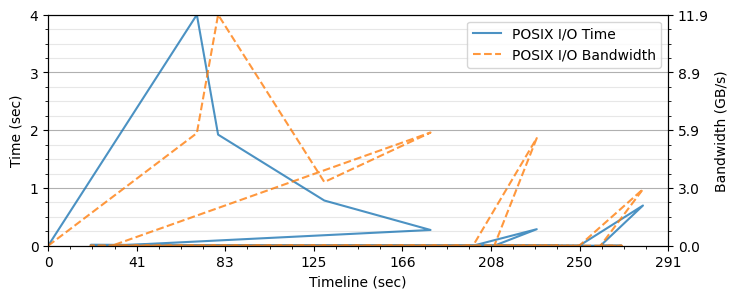

In [23]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit='gb',
    figsize=(8, 3),
    line1_label='POSIX I/O Time',
    line2_label='POSIX I/O Bandwidth',
    time_col='io_time',
    x_num_ticks=8,
    y_num_ticks=5,
)

In [106]:
fig.savefig(f'{app_name}_posix_io_time.pdf', format='pdf', bbox_inches='tight')

TypeError: boolean value of NA is ambiguous

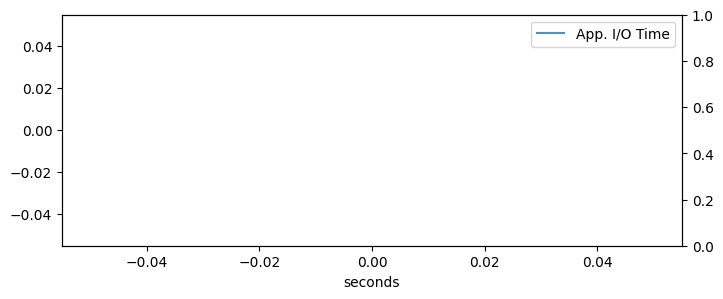

In [24]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit='gb',
    figsize=(8, 3),
    line1_label='App. I/O Time',
    line2_label='App. I/O Bandwidth',
    time_col='app_io_time',
    x_num_ticks=8,
    y_num_ticks=5,
)
ax2.set_visible(False)

In [108]:
fig.savefig(f'{app_name}_app_io_time.pdf', format='pdf', bbox_inches='tight')

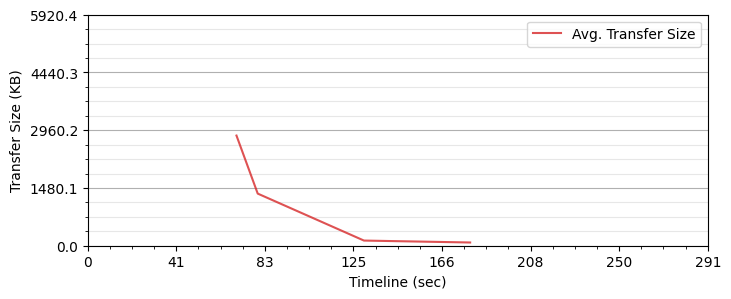

In [25]:
fig, ax = analyzer.plots.xfer_size_timeline(
    figsize=(8, 3),
    unit='kb',
    x_num_ticks=8,
)

In [110]:
fig.savefig(f'{app_name}_xfer_size.pdf', format='pdf', bbox_inches='tight')

In [43]:
analyzer.events.query("cat == 'POSIX'").groupby("name")["size"].mean().compute() / (1024**2)

name
__fxstat64        NaN
__xstat64         NaN
close             NaN
lseek64           NaN
open64            NaN
opendir           NaN
read          0.05467
Name: size, dtype: double[pyarrow]

In [44]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","pid","tid","name"])["io_time"].sum().groupby(["trange","name"]).max().groupby("name").sum().compute() / 1e6

name
__fxstat64     14.238569
__xstat64       0.361658
close          11.435908
lseek64         0.184910
open64         13.368323
opendir         1.125259
read          533.845061
Name: io_time, dtype: double[pyarrow]

In [45]:
val = analyzer.events.groupby(["trange"]).agg({"io_time":[min,max],"compute_time":[min,max],"app_io_time":[min,max]}).sum().compute()
val

io_time       min          0
              max    3614661
compute_time  min        255
              max    3313428
app_io_time   min         26
              max    9089266
dtype: uint64[pyarrow]

In [46]:
val = analyzer.events["app_io_time"].max().compute()
val

9089266

In [47]:
import dask
val1, val2 = dask.compute(analyzer.events["ts"].min() /1e6 , analyzer.events["ts"].max()/1e6)
val2 - val1

761.167636

In [48]:
analyzer.events["hostname"].unique().compute()[:2]

0    x3006c0s13b0n0
Name: hostname, dtype: string

In [49]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","name"])["dur"].max().sum().compute() / 1e6

4.01724

In [50]:
analyzer.events.query("name == 'open'").groupby("trange")["dur"].max().sum().compute() / 1e6

0.0

In [51]:
analyzer.events.groupby(["cat","name"])["dur"].sum().compute()

cat                      name                       
POSIX                    __fxstat64                       444448241
                         __xstat64                          1041137
                         close                            342150487
                         lseek64                            5377747
                         open64                           417437820
                         opendir                            3807348
                         read                           16581944325
IO                       real_IO.iter                     311363925
                         real_IO.yield                   2708610270
communication-except-io  cpu-gpu-transfer                  37165103
compute                  model-compute-backward-prop      444288066
                         model-compute-forward-prop        50921978
Name: dur, dtype: uint64[pyarrow]

In [52]:
3766287/3.8/1e6, 1022647/3.8/1e6, 1080267/3.8/1e6, 178451/3.8/1e6, (1259124+153089)/3.8/1e6

(0.9911281578947368,
 0.26911763157894736,
 0.28428078947368424,
 0.04696078947368421,
 0.371635)